In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Exercise 3.1

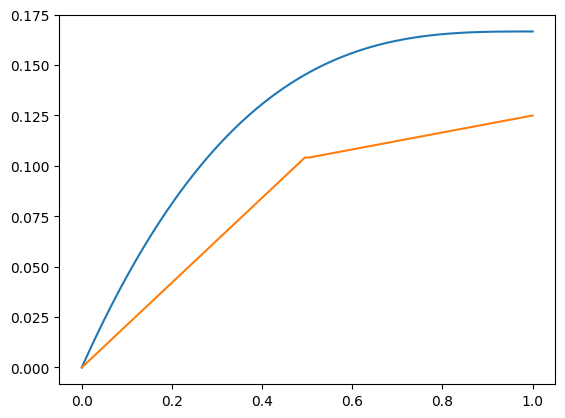

In [62]:
x = np.linspace(0,1,100)
x1 = np.linspace(0,0.5,50)
x2 = np.linspace(0.5,1,50)
z = np.zeros(50)
y = x*(x**2-3*x+3)/6


#N = [[1-x1,z],[2*x1,(2-2*x2)],[z,2*x2-1]]
Ns = [np.concatenate((1-x1,z), axis=0),np.concatenate((2*x1,(2-2*x2)), axis=0),np.concatenate((z,2*x2-1), axis=0)]
k = np.matrix([[-2,2,0],[2,0,2],[0,-2,2]])
f = np.array([5/24,1/4,1/24])
phi = np.linalg.solve(k,f)

phiT = np.zeros(100)

for i,v in enumerate(Ns):
    phiT += phi[i]*v


plt.plot(x,y)
plt.plot(x,phiT)
plt.show()


# Exercise 3.2

In [33]:
def S(x):
    return 1-x

def stiffness(nodes):
    return 1/(nodes[-1]-nodes[0])*np.array([[1,-1],[-1,1]])

def force(nodes,S):
    return ((nodes[-1]-nodes[0])/6)*np.array([2*S(nodes[0])+S(nodes[-1]),S(nodes[0])+2*S(nodes[-1])])

def solver(S,Ne,alpha,beta,even_grid=True):
    if even_grid:
        nodes=np.linspace(0,1,Ne+1)
    else:
        nodes = np.array([0, *sorted(np.random.rand(Ne-1)), 1])

    LM = np.zeros((2, Ne), dtype=np.int64)
    for e in range(Ne):
        if e==0:
            LM[0, e] = -1
            LM[1, e] = 0
        else:
            LM[0, e] = LM[1, e-1]
            LM[1, e] = LM[0, e] + 1

    K = np.zeros((Ne, Ne))
    F = np.zeros((Ne,))

    for e in range(Ne):
        k_e = stiffness(nodes[e:e+2])
        f_e = force(nodes[e:e+2],S)
        
        for a in range(2):
            A = LM[a, e]
            
            for b in range(2):
                B = LM[b, e]
                if (A >= 0) and (B >= 0):
                    K[A, B] += k_e[a, b]
            if (A >= 0):
                F[A] += f_e[a]
        # Modify force vector for Dirichlet BC
        if e == 0:
            F[0] -= alpha * k_e[1, 0]
    # Modify force vector for Neumann BC
    F[-1] += beta
    # Solve
    Psi_A = np.zeros_like(nodes)
    Psi_A[0] = alpha
    Psi_A[1:] = np.linalg.solve(K, F)

    # print(F)
    # print(K)

    return nodes, Psi_A

def linear(x,m,c):
    return m*x+c

def L2_norm_error(pred,aim,x):
    return np.sqrt(((pred[-1]-aim(x))**2))/np.sqrt((aim(x)**2))

def order_of_convergence(analytical,S,alpha,beta,Ns=[10,40,80,160]):
    Psis=[]
    L2_norms=[]
    Ns=np.array(Ns)
    for N in Ns:
        nodes,Psi_N=solver(S,N,alpha,beta)
        Psis.append(Psi_N)
        L2_norms.append(L2_norm_error(Psi_N,analytical,nodes[-1]))
    
    m,c=np.polyfit(np.log(Ns),np.log(L2_norms),1)

    plt.loglog(Ns,(m*Ns)/5E15,'o-',label='m='+str(round(m,3)))
    plt.loglog(Ns,L2_norms,'o-',label='L2 error')
    plt.legend()
    plt.grid(which='both',alpha=.6)
    plt.show()


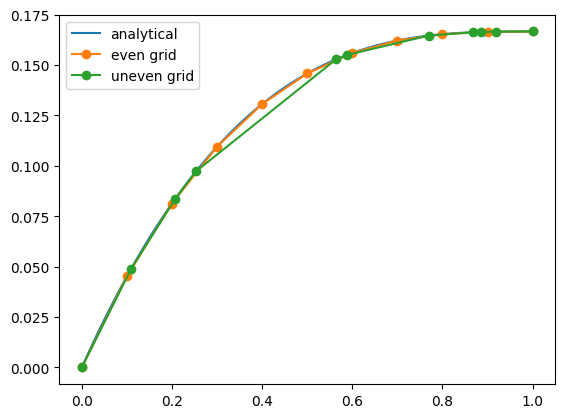

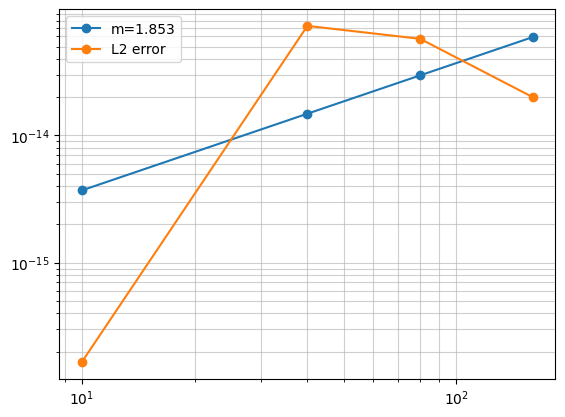

In [41]:
def ana(x):
    return x*(x**2-3*x+3)/6

alpha=0
beta=0
Ne = 10
x,y=solver(S,Ne,alpha,beta)

x_ana=np.linspace(0,1,100)
y_ana=ana(x_ana)
plt.plot(x_ana,y_ana,label='analytical')
plt.plot(x,y,'o-',label='even grid')

x,y=solver(S,Ne,alpha,beta,False)
plt.plot(x,y,'o-',label='uneven grid')

plt.legend()
plt.show()

order_of_convergence(ana,S,alpha,beta)

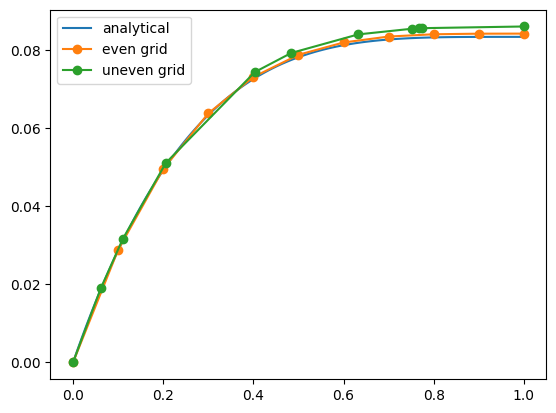

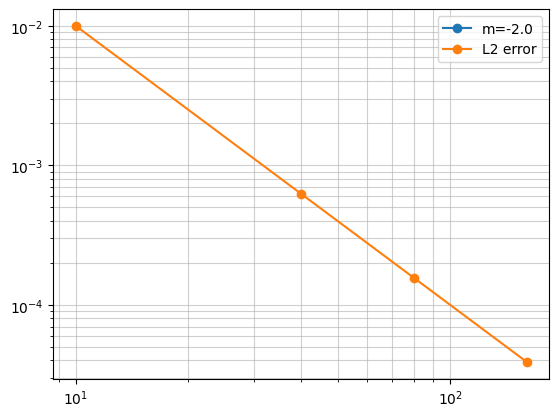

In [40]:
def ana1(x):
    return x*(4-6*x+4*x**2-x**3)/12

x_ana=np.linspace(0,1,100)
y_ana=x_ana*(4-6*x_ana+4*x_ana**2-x_ana**3)/12

def S1(x):
    return (1-x)**2

alpha=0
beta=0
Ne = 10
x,y=solver(S1,Ne,alpha,beta)

plt.plot(x_ana,y_ana,label='analytical')
plt.plot(x,y,'o-',label='even grid')

x,y=solver(S1,Ne,alpha,beta,False)
plt.plot(x,y,'o-',label='uneven grid')

plt.legend()
plt.show()

order_of_convergence(ana1,S1,alpha,beta)

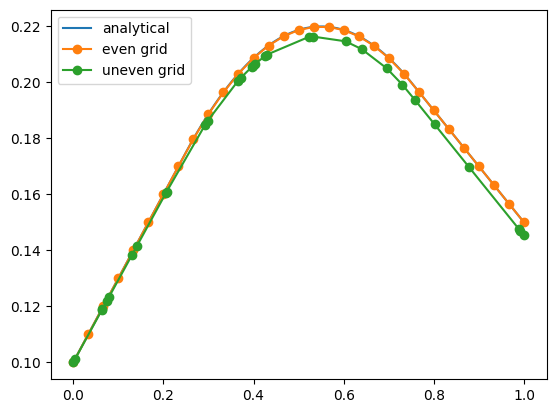

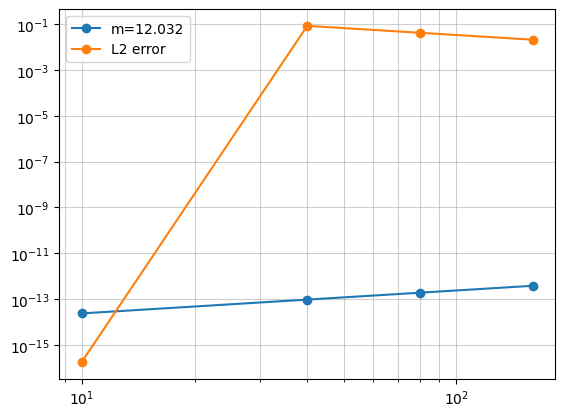

In [45]:
x_ana=np.linspace(0,1,100)
y_ana=np.zeros(len(x_ana))

def psi_ana(x):
    if x<.25:
        return .3*x+.1
    elif .25<x<.75:
        return -.5*x**2+.55*x+11/160
    elif x>.75:
        return -.2*x+.35
    
for i,v in enumerate(x_ana):
    y_ana[i]=psi_ana(v)

def S2(x):
    if abs(x-.5)<.25:
        return 1
    else:
        return 0

alpha=.1
beta=-.2
Ne = 30
x,y=solver(S2,Ne,alpha,beta)

plt.plot(x_ana,y_ana,label='analytical')
plt.plot(x,y,'o-',label='even grid')

x,y=solver(S2,Ne,alpha,beta,False)
plt.plot(x,y,'o-',label='uneven grid')

plt.legend()
plt.show()

order_of_convergence(psi_ana,S2,alpha,beta)

In [19]:
x

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])